In [1]:
import baltic as bt
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from datetime import datetime as dt
from datetime import timedelta, datetime
import time
#import pymc3
import math
import arviz as az
#from hpd import hpd
import scipy.stats as stats
from io import StringIO
import altair as alt
from altair import datum
alt.data_transformers.disable_max_rows()
import seaborn as sns

from zipfile import ZipFile
import scipy as sp


import sys, subprocess, glob, os, shutil, re, importlib
from subprocess import call
import imp


%matplotlib inline
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import matplotlib.colors as clr
from matplotlib import rc
import textwrap as textwrap
from textwrap import wrap

import warnings
warnings.filterwarnings('ignore')

from scipy.special import binom

In [2]:
## read in Nes from BEAST log files
def read_in_Ne_changes_mascot(log_file_path):
    
    Ne_skyline_dict = {"sample":[]}
    
    with open(log_file_path, "r") as infile:
        line_number = 0
        for line in infile:
            line_number += 1
            if not line.startswith("#"):  # log combiner will sometimes put the entire xml at the start of the log file
                # use the first line to find the migration rate columns
                #print(line)
            # use the first line to find the migration rate columns
                if "posterior" in line:
                    all_cols = line.split("\t")
                    Ne_column_indices = []   # list to store column indices
                    Nes_key = {}   # dictionary to store the column index to map to column name

                    for i in range(len(all_cols)):
                        col = all_cols[i]
                        if "Ne." in col:
                            Ne_column_indices.append(i)

                    # make an empty dictionary to store Nes and generate dictionary to convert index to name
                    for n in Ne_column_indices:
                        name = line.split("\t")[n]
                        #deme = name.split(".")[1]# the syntax here is "Ne_region.1" where region is deme and 1 is interval 1
                        interval = name.split(".")[1]
                       
                        Nes_key[n] = name
                        Ne_skyline_dict[name] = []


                # read in actual parameter estimates and store in dictionary
                else:
                    sample = line.split("\t")[0]
                    Ne_skyline_dict["sample"].append(sample)

                    for index in Ne_column_indices:
                        name = Nes_key[index]
                        Ne_skyline_dict[name].append(line.split("\t")[index])
                    
                
    return(Ne_skyline_dict)

In [3]:
# make a new dataframe that summarizes the 95% HPD estimate with mean for each interval 
def generate_summary_df(input_df):
    
    
    new_df = pd.DataFrame()

    for i in input_df.columns.tolist():
        if "Ne." in i:
            interval = i.split(".")[1]
            local_series = input_df[i].astype('float').to_numpy()
            mean_log = local_series.mean()
            median_log = np.median(local_series)
            mean_linear = math.exp(mean_log)
            hpd_95 = az.hdi(local_series, 0.95)
            lower_hpd_log_95 = hpd_95[0]
            lower_hpd_linear_95 = math.exp(lower_hpd_log_95)
            upper_hpd_log_95 = hpd_95[1]
            upper_hpd_linear_95 = math.exp(upper_hpd_log_95)
            hpd_50 = az.hdi(local_series, 0.50)
            lower_hpd_log_50 = hpd_50[0]
            lower_hpd_linear_50 = math.exp(lower_hpd_log_50)
            upper_hpd_log_50 = hpd_50[1]
            upper_hpd_linear_50 = math.exp(upper_hpd_log_50)
        
            try:
                local_df = pd.DataFrame.from_dict({"interval":interval, "mean_Ne_log":mean_log,"mean_Ne_linear":mean_linear, 
                                                   "median_Ne_log" : median_log, 
                                                   "upper_hpd_log_95":upper_hpd_log_95,"lower_hpd_log_95":[lower_hpd_log_95], 
                                                   "upper_hpd_log_50":upper_hpd_log_50,"lower_hpd_log_50":lower_hpd_log_50,
                                                   "upper_hpd_linear":upper_hpd_linear_95,"lower_hpd_linear":lower_hpd_linear_95,
                                                   "upper_hpd_linear_50":upper_hpd_linear_50, "lower_hpd_linear_50":lower_hpd_linear_50,
                                                  })
                new_df = new_df.append(local_df)
            except:
                pass
            
    return(new_df)

In [4]:
#calculating transmission rate
def generate_summary_diff_df(input_df):
    
    
    new_df = pd.DataFrame()
   
    for i in input_df.columns.tolist():
        if "Ne." in i:
            interval = i.split(".")[1]
            next_interval = int(interval)+6 #averaging  to reduce noise
            local_series = input_df[i].astype('float').to_numpy()
           
            try:
                new_df["Ne"+ ".diff." + str(interval)] = (52/6)*(np.log(input_df[i].astype("float")) - np.log(input_df["Ne"+"." + str(next_interval)].astype('float')))
            
            
            except KeyError:
                pass 
            
            
    return(new_df)

In [5]:
log_file_path = "../multitree_coalescent/results/main/multicoal_smoothed_multicoal_case_prior_la_clusters_with_metadata_01_22.log"


In [6]:
Ne_skyline = read_in_Ne_changes_mascot(log_file_path)

#burnin
Ne_df = pd.DataFrame.from_dict(Ne_skyline)
print(len(Ne_df))
Ne_df

burnin_percent = 0.3
print(len(Ne_df))
rows_to_remove = int(len(Ne_df)* burnin_percent) ## remove burnin
Ne_df = Ne_df.iloc[rows_to_remove:]

print(len(Ne_df))
Ne_df = Ne_df.reset_index()
Ne_df.head()

4449
4449
3115


,index,sample,Ne.1,Ne.2,Ne.3,Ne.4,Ne.5,Ne.6,Ne.7,Ne.8,...,Ne.130,Ne.131,Ne.132,Ne.133,Ne.134,Ne.135,Ne.136,Ne.137,Ne.138,Ne.139
0,1334,66700000,-0.4150492051091268,-1.6486474195806042,-0.21226787930151833,-1.0388731392194992,0.4503062332291473,1.6592135977126616,-0.6016601666415693,-1.4606176795731745,...,0.9934582850687185,-0.8799907487007589,-0.7749585974519368,-3.2692068618142867,-2.986583475609112,-3.4963680260578243,-4.07409175415696,-3.934615484141743,-3.6423136320674363,-2.1114730944822333
1,1335,66750000,-3.121420831197207,-2.9812271622183864,-2.0550811206424937,-0.757269839346789,-0.2548725711791453,0.013937288113646983,-0.22107789977662876,-1.6564319616023484,...,1.0665457118237456,-1.0460954831239502,-0.18642644004509076,-2.3443642886180838,-1.998287116130621,-3.922454808163583,-3.9296788852167945,-3.2653387459411807,-1.9873012899395701,-2.218165903320699
2,1336,66800000,-3.0621602559055874,-3.0442725264941397,-2.500179451779213,0.45805921972253605,2.1987529291897268,2.9419986751771994,0.5842782068408559,0.1663906530648381,...,0.5319908086922801,-1.4747410112197725,-0.07038254712550668,-1.8261312878512734,-4.070300009581117,-4.358258234061046,-4.775973198323807,-4.240421037483388,-3.420015389775883,-1.249489881244836
3,1337,66850000,-0.9267055027591731,-2.073725770925092,-0.11620036695987819,0.33775727722827353,0.8783187290142405,0.31105615533046505,1.9447586222774824,1.7575038750783716,...,0.8725293322635398,-0.18098673475097468,-0.43796290298533097,-2.338004102534577,-2.2876650472042104,-2.4427382846010706,-3.9964116106358096,-3.4587398068797413,-1.83126089072077,-1.2859032671393118
4,1338,66900000,-2.0291882239609826,-1.7167622668345137,-0.8820287533445242,0.6932068815822862,-0.23022994024680069,-0.2554833693127013,-0.09465608448414907,-1.1772066904063456,...,1.3682461341340664,-0.8871183348190032,-0.20536640847336876,-2.5795714745019165,-2.1548824289767636,-2.657604200818937,-2.3079800716059564,-3.2009902686235594,-2.5553150350999703,-2.33163191031504


In [7]:
exp_ne_df = Ne_df.copy()
# Select only numeric columns excluding the first two columns
numeric_columns = exp_ne_df.columns[2:]  # Exclude the first two columns

# Apply the exponential function only to numeric columns
exp_ne_df[numeric_columns] = exp_ne_df[numeric_columns].apply(pd.to_numeric, errors='coerce').apply(np.exp)


uninfectious_rate = 365/4.5

#taken from https://www.medrxiv.org/content/10.1101/2022.08.17.22278897v1.full.pdf
incubation_period = 365/8

#calculate transmission rate based on SEIR dynamics
ne_diff_summary = generate_summary_diff_df(exp_ne_df)
seir_growth_rate = ((ne_diff_summary*2 + uninfectious_rate + incubation_period)**2 - (incubation_period- uninfectious_rate)**2)/(4*incubation_period)
seir_growth_rate.head()

,Ne.diff.1,Ne.diff.2,Ne.diff.3,Ne.diff.4,Ne.diff.5,Ne.diff.6,Ne.diff.7,Ne.diff.8,Ne.diff.9,Ne.diff.10,...,Ne.diff.124,Ne.diff.125,Ne.diff.126,Ne.diff.127,Ne.diff.128,Ne.diff.129,Ne.diff.130,Ne.diff.131,Ne.diff.132,Ne.diff.133
0,85.660926,76.642673,125.862775,83.345837,138.710519,171.899422,81.023432,18.707761,9.055616,45.993493,...,162.070063,188.996510,174.121563,236.572794,216.519691,281.740062,245.384028,170.009287,163.675215,55.446318
1,25.136454,52.107234,49.532612,113.082763,72.506969,88.963484,86.019840,37.538955,19.480780,14.764513,...,152.194196,213.767669,147.256676,193.046733,192.471263,259.806307,242.485235,142.645289,129.804610,78.099220
2,15.216145,20.787718,35.446127,130.240117,192.598192,145.434117,100.775798,73.718242,41.626492,20.160804,...,152.097793,251.273931,134.080039,197.283430,281.984214,261.336611,255.278260,160.284600,180.221646,67.776413
3,25.557279,13.042297,84.722314,131.395968,149.151182,111.531433,155.621204,107.240723,31.264689,10.356956,...,182.223229,166.721282,144.177632,225.735463,198.976956,243.439118,237.353819,177.706965,117.849342,57.605042
4,40.700069,68.601073,113.607398,131.744685,114.013888,100.559047,97.401671,60.145943,15.317678,41.297570,...,156.267649,232.742578,159.363860,238.420377,195.581948,225.204623,191.861611,145.629575,146.775082,75.243399


In [8]:
ne_summary = generate_summary_df(Ne_df)
test = ne_summary
test['days'] = (test.interval.astype(int) -3 )*7
test['date'] = dt.strptime("2024-12-12",  "%Y-%m-%d") - test.days.map(timedelta)
test = test.reset_index()

#calculate three week rolling mean
columns = ["mean_Ne_linear", "upper_hpd_linear_50","lower_hpd_linear_50", "lower_hpd_linear", "upper_hpd_linear"]
for column in columns:
    # Create a new column for the moving average
    test[f'{column}_MA'] = test[column].rolling(3, min_periods =1).mean()



In [9]:
range_ = ['#EEC060', '#2664A5', '#A76BB1', "#EEA160", "#356D4C"]
line_ne = alt.Chart(test).mark_area(interpolate='monotone', opacity = 1, clip = True, color = "#7c5981").encode(
    alt.X('date:T', axis=alt.Axis(title="", grid=False,tickCount = "month",  format="%B %Y")),
    alt.Y('lower_hpd_linear_50_MA',axis=alt.Axis(title="Ne (magenta)", grid=False),scale=alt.Scale(domain=(0, 60))),
    alt.Y2('upper_hpd_linear_50_MA' ),
    
).properties(
    width=900,
    height=300)

band_ne = alt.Chart(test).mark_area(interpolate='monotone', opacity = 0.5, clip = True, color = "#7c5981").encode(
    alt.X('date:T', axis=alt.Axis(title="", grid=False, format="%B %Y")),
    alt.Y('lower_hpd_linear_MA',axis=alt.Axis(title="Ne (magenta)", grid=False)),#,scale=alt.Scale(domain=(0, 13))),
    alt.Y2('upper_hpd_linear_MA' ),
    
).properties(
    width=900,
    height=300
)

line_ne  + band_ne


alt.LayerChart(...)

In [10]:
la_mpox_cases_df = pd.read_csv("../multitree_coalescent/data/monkeypox_data.csv")
la_mpox_cases_df = la_mpox_cases_df.dropna(how = "all").dropna(axis = "columns", how = "all")
la_mpox_cases_df = la_mpox_cases_df.rename(columns= {"Unnamed: 0": "date"}); la_mpox_cases_df.head()

,date,cases
0,2022-05-19,1
1,2022-05-20,0
2,2022-05-21,0
3,2022-05-22,0
4,2022-05-23,0


In [11]:
cases = alt.Chart(la_mpox_cases_df).mark_bar(interpolate='monotone', opacity = 0.5, size = 1).encode(
    alt.X('date:T', axis=alt.Axis(title="", tickCount = "month",grid=False, format="%B %Y")),
    alt.Y('cases',axis=alt.Axis(title="Cases (Blue)", grid=False))
).properties(
    width=900,
    height=300
)

(cases + line_ne).resolve_scale(y = "independent")

alt.LayerChart(...)

In [12]:
#switching to migration

In [13]:
def read_in_forward_migration_rates_mascot(log_file_path):
    
    mig_rates_dict = {"sample":[]}
    
    with open(log_file_path, "r") as infile:
        line_number = 0
        for line in infile:
            #print(line_number)
            line_number += 1
            if not line.startswith("#"):  # log combiner will sometimes put the entire xml at the start of the log file
                # use the first line to find the migration rate columns
                
            # use the first line to find the migration rate columns
                if "posterior" in line:
                    all_cols = line.split("\t")
                    mig_column_indices = []   # list to store column indices
                    mig_key = {}   # dictionary to store the column index to map to column name

                    for i in range(len(all_cols)):
                        col = all_cols[i]
                        if "immigrationRate" in col:
                            mig_column_indices.append(i)

                    # make an empty dictionary to store Nes and generate dictionary to convert index to name
                    for n in mig_column_indices:
                        name = line.split("\t")[n]
                        interval = name.split(".")[1]# the syntax here is "NeLog.state01" where 0 is deme and 1 is interval 1
                        #interval = name.split(".")[2]
                       
                        mig_key[n] = name
                        mig_rates_dict[name] = []


                # read in actual parameter estimates and store in dictionary
                else:
                    sample = line.split("\t")[0]
                    mig_rates_dict["sample"].append(sample)

                    for index in mig_column_indices:
                        name = mig_key[index]
                        mig_rates_dict[name].append(line.split("\t")[index])           
                
                
    return(mig_rates_dict)

In [14]:
# make a new dataframe that summarizes the 95% HPD estimate with mean for each deme and interval 
def generate_summary_df(input_df):
    
    
    new_df = pd.DataFrame()

    for i in input_df.columns.tolist():
        if "immigrationRate." in i:
            interval = i.split(".")[1]
           # print(interval)
            #print(interval)
            #print(i)
            #next_interval = int(interval)+1
            local_series = input_df[i].astype('float').to_numpy()
            #print(local_series)
            mean_log = local_series.mean()
            median_log = np.median(local_series)
            mean_linear = math.exp(mean_log)
            hpd_95 = az.hdi(local_series, 0.95)
            lower_hpd_log_95 = hpd_95[0]
            lower_hpd_linear_95 = math.exp(lower_hpd_log_95)
            upper_hpd_log_95 = hpd_95[1]
            upper_hpd_linear_95 = math.exp(upper_hpd_log_95)
            hpd_50 = az.hdi(local_series, 0.50)
            lower_hpd_log_50 = hpd_50[0]
            lower_hpd_linear_50 = math.exp(lower_hpd_log_50)
            upper_hpd_log_50 = hpd_50[1]
            upper_hpd_linear_50 = math.exp(upper_hpd_log_50)

            
            try:
                local_df = pd.DataFrame.from_dict({"interval":interval, "mean_mig_log":mean_log,"mean_mig_linear":mean_linear, 
                                                   "median_mig_log" : median_log, 
                                                   "upper_hpd_log_95":upper_hpd_log_95,"lower_hpd_log_95":[lower_hpd_log_95], 
                                                   "upper_hpd_log_50":upper_hpd_log_50,"lower_hpd_log_50":lower_hpd_log_50,
                                                   "upper_hpd_linear":upper_hpd_linear_95,"lower_hpd_linear":lower_hpd_linear_95,
                                                   "upper_hpd_linear_50":upper_hpd_linear_50, "lower_hpd_linear_50":lower_hpd_linear_50,
                                                  })
                new_df = new_df.append(local_df)
                #print(new_df)
            except:
                pass
            
   
            

            
    return(new_df)

In [15]:
migration_rates_f = read_in_forward_migration_rates_mascot(log_file_path)
mig_df_f = pd.DataFrame.from_dict(migration_rates_f)

#remove burnin
burnin_percent = 0.3
print(len(mig_df_f))
rows_to_remove = int(len(mig_df_f)* burnin_percent)
mig_df_f = mig_df_f.iloc[rows_to_remove:]

print(len(mig_df_f))
mig_df_f = mig_df_f.reset_index()
mig_df_f.head()

4449
3115


,index,sample,immigrationRate.1,immigrationRate.2,immigrationRate.3,immigrationRate.4,immigrationRate.5,immigrationRate.6,immigrationRate.7,immigrationRate.8,...,immigrationRate.129,immigrationRate.130,immigrationRate.131,immigrationRate.132,immigrationRate.133,immigrationRate.134,immigrationRate.135,immigrationRate.136,immigrationRate.137,immigrationRate.138
0,1334,66700000,-1.4283361361286757,-0.46485542994196016,0.6085976830182345,-0.09508524571561049,-0.4878072571131238,-0.9579833162812611,-1.0571928323517727,-0.5220745287252839,...,2.493151405340156,2.1333669956526875,2.940099604557461,2.3599861169066028,2.5442182497189285,2.782769095293822,2.6763615846942153,2.237864358771005,2.858790529847559,2.743341411614092
1,1335,66750000,0.9373411360414724,1.294170581919156,1.0204309947648615,0.543059142800109,-0.04062008232317779,-1.6521575051898314,-1.1130049838630307,-1.585196946172903,...,2.8575957976515003,2.7104061585565105,2.98261332892712,2.882878632849613,2.0628633356800767,2.3579043235942074,2.0760533931371272,2.1676748192519955,2.1675601195821512,1.4754657378307108
2,1336,66800000,1.0483938359735634,0.6838521532420206,0.777687213417006,0.44830175177429316,0.5413564369163945,1.0211465501039911,-0.44864750279042986,-0.9843215226283081,...,2.5256035268011416,2.2848025329196777,2.482422116676094,1.8878854756418622,2.015647703599142,2.694092595324931,1.9936580118536162,1.522257338005721,0.6622229443290322,1.570888922251831
3,1337,66850000,-1.3291360147614155,-1.209228417618184,-1.1389887651938333,-0.27128686745303615,-0.42191840732051306,-0.4062120315291242,0.11899659448191773,-0.11653498280636129,...,2.461258550178066,2.5160203283179174,3.502378241069932,3.405345058482367,3.110513884281638,2.7549612299319,3.2862865771964156,2.80808179924075,2.8412315238288492,2.2266112343610778
4,1338,66900000,-1.0122046350453948,-0.6716735095728821,-0.34619350614397604,-0.2606446272992706,-0.8470858803141886,-0.9300928487428134,-0.7524168789514294,-1.1855275125306284,...,2.710677691321528,2.7593719829312406,2.9242813382761796,3.339462961048558,3.6741321038190624,3.366951839599576,2.7227945831369333,2.627521748626604,2.9929548032899196,2.7174227542460043


In [16]:
mig_summary = generate_summary_df(mig_df_f)
mig_summary.head()

,interval,mean_mig_log,mean_mig_linear,median_mig_log,upper_hpd_log_95,lower_hpd_log_95,upper_hpd_log_50,lower_hpd_log_50,upper_hpd_linear,lower_hpd_linear,upper_hpd_linear_50,lower_hpd_linear_50
0,1,-0.606085,0.545482,-0.538128,1.811774,-3.392809,0.483221,-1.178409,6.121298,0.033614,1.621288,0.307768
0,2,-0.598220,0.549789,-0.522949,1.734311,-3.142245,0.377117,-1.183036,5.665025,0.043186,1.458074,0.306347
0,3,-0.579932,0.559937,-0.506013,1.547813,-3.129088,0.301370,-1.225017,4.701176,0.043758,1.351710,0.293753
0,4,-0.552191,0.575687,-0.492920,1.618991,-2.790347,0.191129,-1.297190,5.047996,0.061400,1.210616,0.273299
0,5,-0.507751,0.601847,-0.426653,1.559658,-2.597044,0.423113,-1.010034,4.757193,0.074493,1.526707,0.364207


In [17]:
#format dates
test_mig = mig_summary
test_mig['days'] = (test_mig.interval.astype(int) -3 )*7
test_mig['date'] = dt.strptime("2024-12-12",  "%Y-%m-%d") - test_mig.days.map(timedelta)

In [18]:
#domain = ['CentralEurope', 'NorthAmerica', 'SouthAmerica' ,"SouthernEurope", "WesternEurope"]
range_ = ['#EEC060', '#2664A5', '#A76BB1', "#EEA160", "#356D4C"]
line_mig = alt.Chart(test_mig).mark_area(interpolate='monotone', opacity = 0.8).encode(
    alt.X('date:T', axis=alt.Axis(title="", grid=False,tickCount = "month",  format="%B %Y")),
    alt.Y('lower_hpd_linear_50',axis=alt.Axis(title="Immigration Rate (migration events/lineage/year)", grid=False)),#,scale=alt.Scale(domain=(0, 13))),
    alt.Y2('upper_hpd_linear_50' ),
    
).properties(
    width=900,
    height=300
)

band_mig = alt.Chart(test_mig).mark_area(interpolate='monotone', opacity = 0.2, clip = True).encode(
    alt.X('date:T', axis=alt.Axis(title="", grid=False,tickCount = "month",  format="%B %Y")),
    alt.Y('lower_hpd_linear',axis=alt.Axis(title="Immigration Rate (migration events/lineage/year)", grid=False), scale=alt.Scale(domain=(0, 100))),
    alt.Y2('upper_hpd_linear' ),
    
).properties(
    width=900,
    height=300
)


mig_plot = (line_mig + band_mig)
mig_plot

alt.LayerChart(...)

In [19]:
## percentage of cases due to introductions

In [20]:
def generate_percent_intro_df(input_df):
    
    temp_df = pd.DataFrame()
    new_df = pd.DataFrame()
   
    for i in input_df.columns.tolist():
        if "immigrationRate" in i:
        
            interval = i.split(".")[1]
            #deme = i.split(".")[2]

            try:
                temp_df["total."+ str(interval)] = seir_growth_rate["Ne.diff." + str(interval)].astype("float") +  input_df[i].astype("float").apply(np.exp)
                new_df["intro.percent"+ "." + str(interval)] = input_df[i].astype("float").apply(np.exp).div(temp_df["total."+ str(interval)], axis = 0) 

            except KeyError: #this was added because not all regions have equal time periods for their epidemics and it was throwing an error everytime it had to switch deme
                pass 
                  
    return(new_df)

In [21]:
# make a new dataframe that summarizes the 95% HPD estimate with mean for each deme and interval 
def generate_summary_df(input_df):
    
    
    new_df = pd.DataFrame()

    for i in input_df.columns.tolist():
        if "percent" in i:
            interval = i.split(".")[2]
            #interval = i.split(".")[3]
            local_series = input_df[i].astype('float').to_numpy()
            #print(local_series)
            mean_percent = local_series.mean()
            hpd_95 = az.hdi(local_series, 0.95)
            lower_hpd_log_95 = hpd_95[0]
            upper_hpd_log_95 = hpd_95[1]
            hpd_50 = az.hdi(local_series, 0.50)
            lower_hpd_log_50 = hpd_50[0]
            upper_hpd_log_50 = hpd_50[1]
            

            
            
            try:
                local_df = pd.DataFrame.from_dict({ "interval":interval, "mean_percent":mean_percent, 
                                                   "upper_hpd_log_95":upper_hpd_log_95,"lower_hpd_log_95":[lower_hpd_log_95], 
                                                   "upper_hpd_log_50":upper_hpd_log_50,"lower_hpd_log_50":lower_hpd_log_50})
                new_df = new_df.append(local_df)
            except:
                pass
            
    return(new_df)


In [22]:
percent_df = generate_percent_intro_df(mig_df_f)
percent_df.head()

,intro.percent.1,intro.percent.2,intro.percent.3,intro.percent.4,intro.percent.5,intro.percent.6,intro.percent.7,intro.percent.8,intro.percent.9,intro.percent.10,...,intro.percent.124,intro.percent.125,intro.percent.126,intro.percent.127,intro.percent.128,intro.percent.129,intro.percent.130,intro.percent.131,intro.percent.132,intro.percent.133
0,0.002791,0.008130,0.014392,0.010792,0.004407,0.002227,0.004270,0.030739,0.045308,0.011214,...,0.037834,0.036041,0.034593,0.056486,0.062515,0.041177,0.033264,0.100132,0.060774,0.186761
1,0.092207,0.065428,0.053041,0.014993,0.013070,0.002149,0.003805,0.005429,0.018795,0.016335,...,0.028506,0.025406,0.038835,0.097339,0.075573,0.062835,0.058385,0.121559,0.120983,0.091528
2,0.157896,0.087025,0.057849,0.011878,0.008843,0.018733,0.006296,0.005044,0.014866,0.039660,...,0.023875,0.017515,0.056541,0.057751,0.057935,0.045642,0.037056,0.069491,0.035356,0.099700
3,0.010251,0.022370,0.003765,0.005769,0.004378,0.005937,0.007186,0.008231,0.031925,0.072094,...,0.020686,0.028720,0.037642,0.050600,0.044449,0.045930,0.049570,0.157393,0.203581,0.280275
4,0.008850,0.007392,0.006188,0.005815,0.003746,0.003908,0.004815,0.005055,0.016280,0.006756,...,0.014872,0.015933,0.047016,0.040236,0.042615,0.062601,0.076040,0.113369,0.161185,0.343757


In [23]:
summary_percent_df = generate_summary_df(percent_df)
summary_percent_df = summary_percent_df.reset_index()

#making sure that any numbers >1 are excluded as outliers from stochastic noise
percent_df =pd.DataFrame(np.where(percent_df <1, percent_df, 1), columns=percent_df.columns )
percent_df =pd.DataFrame(np.where(percent_df >0, percent_df, 0), columns=percent_df.columns )

#format dates
summary_percent_df['days'] = (summary_percent_df.interval.astype(int)-3)*7 #the 3 adjustment is made due to the fact that we take the difference of Nes over three weeks 
summary_percent_df['date'] = dt.strptime("2024-12-12",  "%Y-%m-%d") - summary_percent_df.days.map(timedelta)

summary_percent_df.head()

,index,interval,mean_percent,upper_hpd_log_95,lower_hpd_log_95,upper_hpd_log_50,lower_hpd_log_50,days,date
0,0,1,0.030533,0.122644,0.000031,0.011332,0.000053,-14,2024-12-26
1,0,2,0.034382,0.156354,0.000043,0.014203,0.000064,-7,2024-12-19
2,0,3,0.039274,0.135330,0.000053,0.013729,0.000332,0,2024-12-12
3,0,4,0.023515,0.078248,0.000054,0.011263,0.000405,7,2024-12-05
4,0,5,0.016769,0.053004,0.000046,0.009123,0.000466,14,2024-11-28


In [24]:
columns = ["mean_percent", "upper_hpd_log_95","lower_hpd_log_95", "upper_hpd_log_50", "lower_hpd_log_50"]
for column in columns:
    # Create a new column for the moving average
    summary_percent_df[f'{column}_MA'] = summary_percent_df[column].rolling(6, min_periods =1).mean()


In [25]:
line1 = alt.Chart(summary_percent_df).mark_area(interpolate='monotone', opacity = 0.9, clip = True, color = "#7c5981").encode(
    alt.X('date:T', axis=alt.Axis(title="",tickCount = "month",grid=False,  format="%b %Y")),
    alt.Y('lower_hpd_log_50_MA',title = "Percent of new cases due to introductions (magenta)", axis=alt.Axis( grid=False, format='%', ), scale=alt.Scale(domain=(0.0, .3))),
    alt.Y2('upper_hpd_log_50_MA' )
).properties(
    width=900,
    height=300
)

band = alt.Chart(summary_percent_df).mark_area(interpolate='monotone', opacity = 0.2, clip = True, color = "#7c5981").encode(
    alt.X('date:T', axis=alt.Axis(title="",tickCount = "month",grid=False,  format="%b %Y")),
    alt.Y('lower_hpd_log_95_MA',title = "Percent of new cases due to introductions (magenta)", axis=alt.Axis( grid=False, format='%', ), scale=alt.Scale(domain=(0.0, .3))),
    alt.Y2('upper_hpd_log_95_MA' )
).properties(
    width=900,
    height=300
)


intro_plot = (line1 + band).resolve_scale(y= "shared") ; intro_plot

alt.LayerChart(...)

In [26]:
## calculate Rt

In [27]:
def generate_local_and_intro_rt(input_df):
    
    
    new_df = pd.DataFrame()
    incubation_period = 365/8
    uninfectious_rate = 365/4.5
    
    for i in input_df.columns.tolist():
        if "Ne" in i:
            interval = i.split(".")[2]
            new_df["rt" +  "." + str(interval)] = (1+ (input_df[i].astype("float") / uninfectious_rate)) * (1+ (input_df[i].astype("float") / incubation_period))
            

            
    return(new_df)

In [28]:
def generate_local_rt(input_df):
    
    
    new_df = pd.DataFrame()
    incubation_period = 365/8
    uninfectious_rate = 365/4.5
    
    for i in input_df.columns.tolist():
        if "Ne" in i:
            interval = i.split(".")[2]
            try:
                new_df["rt" + "." + str(interval)] = ((1+ (input_df[i].astype("float") / uninfectious_rate)) * (1+ (input_df[i].astype("float") / incubation_period))) *  (1- percent_df["intro.percent."+str(interval)].astype("float"))
                
            except KeyError:
                pass

            
    return(new_df)

In [29]:
# make a new dataframe that summarizes the 95% HPD estimate with mean for each deme and interval 
def generate_rt_summary_df(input_df):
    
    
    new_df = pd.DataFrame()
    count = 0
    for i in input_df.columns.tolist():
        #print(i)
        if "rt" in i:
            if count %1 == 0:
                interval = i.split(".")[1]
                #interval = i.split(".")[2]
                local_series = input_df[i].astype('float').to_numpy()
                mean_percent = local_series.mean()
                median_percent = np.median(local_series)

                hpd_95 = az.hdi(local_series, 0.95)
                lower_hpd_log_95 = hpd_95[0]
                upper_hpd_log_95 = hpd_95[1]
                hpd_50 = az.hdi(local_series, 0.50)
                lower_hpd_log_50 = hpd_50[0]
                upper_hpd_log_50 = hpd_50[1]

                try:
                    local_df = pd.DataFrame.from_dict({"interval":interval, "mean_percent":mean_percent, "median_percent":median_percent,
                                                       "upper_hpd_log_95":upper_hpd_log_95,"lower_hpd_log_95":[lower_hpd_log_95], 
                                                       "upper_hpd_log_50":upper_hpd_log_50,"lower_hpd_log_50":lower_hpd_log_50})
                    new_df = new_df.append(local_df)
                except:
                    pass
            count+=1

    return(new_df)

In [30]:
# a line to show an Rt of 1
one_line = alt.Chart(pd.DataFrame({'y': [1.0]})).mark_rule(strokeDash=[1,1]).encode(y='y').properties(
    width=900,
    height=300
)

In [31]:
#read in data and calculate based on posterior set of trees
rt_local_and_intro_df = generate_local_and_intro_rt(ne_diff_summary)
rt_local_df = generate_local_rt(ne_diff_summary)

#summarize data
summary_rt_local_and_intro_df = generate_rt_summary_df(rt_local_and_intro_df)
summary_rt_local_df = generate_rt_summary_df(rt_local_df)

summary_rt_local_and_intro_df.head()

,interval,mean_percent,median_percent,upper_hpd_log_95,lower_hpd_log_95,upper_hpd_log_50,lower_hpd_log_50
0,1,0.732149,0.653602,1.606908,-0.014321,0.776627,0.274286
0,2,0.604429,0.539601,1.330037,-0.084981,0.694181,0.266884
0,3,0.627739,0.570311,1.410492,-0.004618,0.716958,0.266055
0,4,0.779283,0.717577,1.609350,0.067944,0.909133,0.430917
0,5,0.953123,0.903762,1.744817,0.233741,1.080193,0.585391


In [32]:
summary_rt_local_and_intro_df['days'] = (summary_rt_local_and_intro_df.interval.astype(int) -3) *7
summary_rt_local_and_intro_df['date'] = dt.strptime("2024-12-12",  "%Y-%m-%d") - summary_rt_local_and_intro_df.days.map(timedelta)

summary_rt_local_df['days'] = (summary_rt_local_df.interval.astype(int) -3) *7
summary_rt_local_df['date'] = dt.strptime("2024-12-12",  "%Y-%m-%d") - summary_rt_local_df.days.map(timedelta)

summary_rt_local_and_intro_df["contribution"] = "Local + Introductions"
summary_rt_local_df["contribution"] = "Local"

In [33]:
columns = ["mean_percent","median_percent", "upper_hpd_log_95","lower_hpd_log_95", "upper_hpd_log_50", "lower_hpd_log_50"]
for column in columns:
    # Create a new column for the moving average
    summary_rt_local_and_intro_df[f'{column}_MA'] = summary_rt_local_and_intro_df[column].rolling(6, min_periods =1).mean()
    summary_rt_local_df[f'{column}_MA'] = summary_rt_local_df[column].rolling(6, min_periods =1).mean()


In [34]:
combined_rt_df = pd.concat([summary_rt_local_and_intro_df,summary_rt_local_df], ignore_index = True )

In [35]:
rt_line2 = alt.Chart(combined_rt_df).mark_area(interpolate='monotone', opacity = 0.7, clip = True).encode(
    alt.X('date:T', axis=alt.Axis(title="",tickCount = "month", grid=False,format="%B %Y")),
    alt.Y('lower_hpd_log_50_MA',axis=alt.Axis(title="Phylo-estimated Rt", grid=False)),
    alt.Y2('upper_hpd_log_50_MA' ),
    alt.Color("contribution", legend=alt.Legend(title = "Rt contribution", offset=-400, labelLimit = 400))
).properties(
    width=900,
    height=300
)
rt_band2 = alt.Chart(combined_rt_df).mark_area(
    opacity=0.3, interpolate='monotone'
).encode(
    alt.X('date:T', axis=alt.Axis(title="", grid=False,format="%B %Y")),
    alt.Y('lower_hpd_log_95_MA', axis=alt.Axis(title="Phylo-estimated Rt", grid=False)),# scale=alt.Scale(domain=(0.6, 1.3))),
    alt.Y2('upper_hpd_log_95_MA'), 
    alt.Color("contribution")
).properties(
    width=900,
    height=300
)

stream_plot_rt =    rt_band2+rt_line2 + one_line

stream_plot_rt

alt.LayerChart(...)

In [36]:
line_simple_intro = alt.Chart(combined_rt_df).mark_line(interpolate='monotone', opacity = 1, clip = True, strokeDash=[5,1]).encode(
    alt.X('date:T', axis=alt.Axis(title="",tickCount = "month", grid=False,format="%B %Y")),
    alt.Y('mean_percent_MA',scale=alt.Scale(domain=[0.5, 2]),axis=alt.Axis(title="Phylo-estimated Rt", grid=False)),
    alt.Color("contribution", legend=alt.Legend(offset=-400, labelLimit = 400))

).properties(
    width=900,
    height=300
)


line_rt = line_simple_intro+ one_line; line_rt

alt.LayerChart(...)

In [37]:
alt.layer(intro_plot, stream_plot_rt).resolve_scale(y= "independent").configure_axis(
    labelFontSize=20,
    titleFontSize=13
).configure_legend(
    labelFontSize = 20, 
    titleFontSize = 20)

alt.LayerChart(...)

In [38]:
alt.layer(mig_plot, line_rt).resolve_scale(y= "independent")

alt.LayerChart(...)

In [39]:
cases_ne = (cases + line_ne)#.resolve_scale(y= "shared"); cases_ne

In [40]:
alt.layer(cases_ne,stream_plot_rt).resolve_scale(y = "independent").configure_axis(
    labelFontSize=24,
    titleFontSize=18
).configure_legend(
    labelFontSize = 20, 
    titleFontSize = 20)

alt.LayerChart(...)

In [41]:
line_rt

alt.LayerChart(...)

In [42]:
## compare Rts

In [49]:
case_rt = pd.read_csv("../data/case-rt-estimates_region.tsv", sep = "\t"); case_rt.head()
case_rt['label'] = "case-based Rt"

In [139]:
## all the microsimulation results with uncertainty intervals are in seperate folders and files. This function combines all those results
## into a single dataframe. Of note, this specific code snippet was created with help of ChatGPT and 
## edited by Miguel Paredes. The rest of this notebook was written by Miguel. 

# Define the parent folder containing the subfolders
parent_folder = "../data/Microsim results w ci/"

# Initialize an empty list to store the processed DataFrames
dataframes = []

# Loop through each subfolder in the parent folder
for subfolder in os.listdir(parent_folder):
    subfolder_path = os.path.join(parent_folder, subfolder)

    # Check if the current path is a folder and matches the pattern "S0" to "S9"
    if os.path.isdir(subfolder_path) and subfolder.startswith("S"):
        file_path = os.path.join(subfolder_path, "r_t_bs_results.csv")

        # Check if the target file exists in the subfolder
        if os.path.exists(file_path):
            # Read the CSV file into a DataFrame
            df = pd.read_csv(file_path)

            # Rename columns to include the folder name
            folder_name = subfolder
            df.rename(columns={
                "Mean": f"Mean_{folder_name}",
                "UpperBound": f"UpperBound_{folder_name}",
                "LowerBound": f"LowerBound_{folder_name}"
            }, inplace=True)

            # Add the modified DataFrame to the list
            dataframes.append(df)
    
    elif os.path.isdir(subfolder_path) and subfolder.startswith("FoI"):
        file_path = os.path.join(subfolder_path, "infected_per_infectious_bs_results.csv")

        # Check if the target file exists in the subfolder
        if os.path.exists(file_path):
            # Read the CSV file into a DataFrame
            df = pd.read_csv(file_path)
            df.Mean = df.Mean *3 #multiplying by three which is the average time that individuals are infectious with mpox
            df.UpperBound = df.Mean *3
            df.LowerBound = df.Mean *3
            # Rename columns to include the folder name
            folder_name = subfolder
            df.rename(columns={
                "Mean": f"Mean_{folder_name}",
                "UpperBound": f"UpperBound_{folder_name}",
                "LowerBound": f"LowerBound_{folder_name}"
            }, inplace=True)

            # Add the modified DataFrame to the list
            dataframes.append(df)

# Merge all DataFrames on the "Week" column
merged_df = dataframes[0]
for df in dataframes[1:]:
    merged_df = pd.merge(merged_df, df, on="Week")
    
empirical_df = pd.read_csv("../data/microsimulation_results/scenarios_aware.csv")

merged_df = pd.merge(merged_df, empirical_df, left_on = "Week", right_on = "week" )
merged_df.head()

,Week,Mean_S5,LowerBound_S5,UpperBound_S5,Mean_S3,LowerBound_S3,UpperBound_S3,Mean_S4,LowerBound_S4,UpperBound_S4,...,To.Aware_S10,To.Aware_S11,To.Aware_S12,To.Aware_S13,To.Aware_S14,To.Aware_S15,To.Aware_S16,To.Aware_S17,To.Aware_S18,To.Aware_S19
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,1,0.352667,0.150000,0.600000,0.118567,0.050000,0.200000,0.152867,0.050000,0.266667,...,2,1,2,2,2,2,2,2,2,2
2,2,NaN,0.194028,0.571181,0.362393,0.060000,0.761905,0.703674,0.378810,1.079683,...,1,2,0,0,1,1,1,1,1,1
3,3,0.676830,0.257576,1.143074,0.205687,0.050000,0.362411,0.246992,0.088000,0.414952,...,2,1,0,0,1,1,1,0,2,1
4,4,0.333090,0.141667,0.552619,NaN,0.205698,0.889966,NaN,0.014625,0.370500,...,3,1,1,0,1,1,1,1,3,1


In [140]:
start_date = datetime(2023, 3, 1)
modeling_df = merged_df.copy()
modeling_df['week_date'] = modeling_df['Week'].apply(lambda x: (start_date + timedelta(weeks=x)).strftime('%Y-%m-%d'))
#modeling_df = modeling_df.dropna()
modeling_df.head()


,Week,Mean_S5,LowerBound_S5,UpperBound_S5,Mean_S3,LowerBound_S3,UpperBound_S3,Mean_S4,LowerBound_S4,UpperBound_S4,...,To.Aware_S11,To.Aware_S12,To.Aware_S13,To.Aware_S14,To.Aware_S15,To.Aware_S16,To.Aware_S17,To.Aware_S18,To.Aware_S19,week_date
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,2023-03-01
1,1,0.352667,0.150000,0.600000,0.118567,0.050000,0.200000,0.152867,0.050000,0.266667,...,1,2,2,2,2,2,2,2,2,2023-03-08
2,2,NaN,0.194028,0.571181,0.362393,0.060000,0.761905,0.703674,0.378810,1.079683,...,2,0,0,1,1,1,1,1,1,2023-03-15
3,3,0.676830,0.257576,1.143074,0.205687,0.050000,0.362411,0.246992,0.088000,0.414952,...,1,0,0,1,1,1,0,2,1,2023-03-22
4,4,0.333090,0.141667,0.552619,NaN,0.205698,0.889966,NaN,0.014625,0.370500,...,1,1,0,1,1,1,1,3,1,2023-03-29


In [141]:
cluster_r0_2023 = pd.read_csv("../cluster_distributions/cluster_inference_just2023_lessdetect.csv")
cluster_r0_2023

,mle_estim,param,p_detect,lower_95,upper_95,lower_90,upper_90,lower_50,upper_50
0,0.896723,R,0.05,0.850,0.95,0.850,0.940,0.880,0.910
1,0.468642,k,0.05,0.062,10.00,0.086,4.606,0.238,0.960
2,0.863759,R,0.10,0.800,0.94,0.810,0.920,0.840,0.880
3,0.537928,k,0.10,0.085,10.00,0.112,10.000,0.276,1.159
4,0.802415,R,0.25,0.710,0.91,0.720,0.890,0.770,0.830
5,0.610880,k,0.25,0.128,10.00,0.160,10.000,0.335,1.305
6,0.739490,R,0.50,0.620,0.88,0.640,0.850,0.700,0.780
7,0.652073,k,0.50,0.168,10.00,0.203,10.000,0.384,1.293


In [142]:
epifilter_r_df = pd.read_csv("../data/epifilter/epifilter_r_estimates.csv").rename(columns = {"x":"R"})
epifilter_r_ci_df = pd.read_csv("../data/epifilter/epifilter_r_ci_estimates.csv", index_col = False).transpose().reset_index().drop(columns = ["index"]).reset_index().rename(columns = {0: "lb_95", 1:"ub_95", 2:"lb_50", 3:"ub_50"})

In [143]:
epifilter_combined_df = pd.merge(epifilter_r_df, epifilter_r_ci_df,left_index=True, right_index=True)
start_date = datetime(2022, 5, 19)
epifilter_combined_df['date'] = epifilter_combined_df['index'].apply(lambda x: (start_date + timedelta(days=x)).strftime('%Y-%m-%d'))
epifilter_combined_df.date = pd.to_datetime(epifilter_combined_df['date'])


In [144]:
rt_line=  alt.Chart(epifilter_combined_df, title = "").mark_line(interpolate='monotone', opacity = 1 ,color = "#439894", clip = True).encode(
    alt.X('date:T', axis=alt.Axis(title="",tickCount = "month", grid=False,format="%B %Y")),
    alt.Y('R',axis=alt.Axis(title="Rt", grid=False),stack = False),

    #alt.Color('variable:N',legend=alt.Legend(title= "Contribution",offset = 10, labelFontSize = 16, titleFontSize = 20)),


).properties(
    width=800,
    height=300
)#.transform_filter(datum.variable == "Empirical")


rt_band =  alt.Chart(epifilter_combined_df, title = "").mark_area(interpolate='monotone', opacity = 0.3 ,color = "#439894", clip = True).encode(
    alt.X('date:T', axis=alt.Axis(title="",tickCount = "month", grid=False,format="%B %Y")),
    alt.Y('ub_95',axis=alt.Axis(title="Rt", grid=False), scale=alt.Scale(domain=(0, 3))),
    alt.Y2("lb_95")

    #alt.Color('variable:N',legend=alt.Legend(title= "Contribution",offset = 10, labelFontSize = 16, titleFontSize = 20)),


).properties(
    width=800,
    height=300
)#.transform_filter(datum.variable == "Empirical")


epifilter_plot = rt_line + rt_band
epifilter_plot

alt.LayerChart(...)

In [145]:
alt.layer(intro_plot, epifilter_plot).resolve_scale(y= "independent").configure_axis(
    labelFontSize=20,
    titleFontSize=13
).configure_legend(
    labelFontSize = 20, 
    titleFontSize = 20)

alt.LayerChart(...)

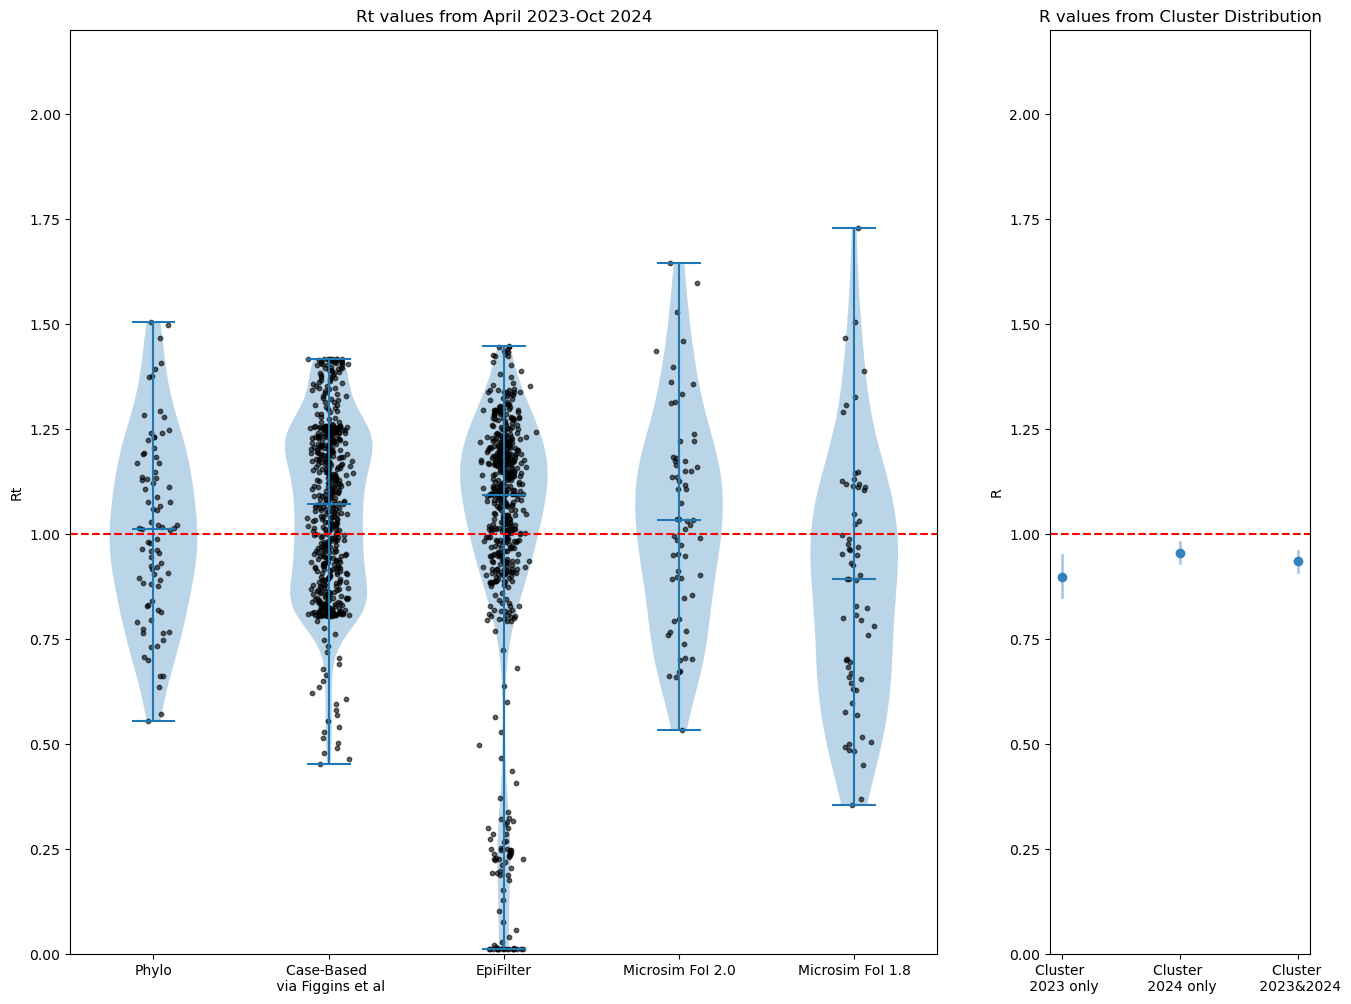

In [146]:
modeling_df.dropna(subset = ['Mean_FoI2_Iso0.2', 'Mean_FoI1.8_Iso0.2'], inplace=True)


start_date ="2023-03-15"
end_date = "2024-10-20"


fig = plt.figure(figsize=(16,12),facecolor='w')

gs = GridSpec(1, 2, width_ratios=[1, 0.3], hspace=0.1)  # three rows, one column
# Add the first subplot 
ax1 = fig.add_subplot(gs[0,0])

# Create violin plots
positions = [1, 2, 3, 4, 5]
means = [combined_rt_df.mean_percent_MA[(combined_rt_df.contribution == "Phylo Rt - Local ")&(combined_rt_df.date > start_date) & (combined_rt_df.date < end_date)], case_rt.median_R[(case_rt.date > start_date) &(case_rt.date < end_date)], epifilter_combined_df.R[(epifilter_combined_df.date > start_date) &(epifilter_combined_df.date < end_date)], modeling_df["Mean_FoI2_Iso0.2"][(modeling_df.week_date > start_date) & (modeling_df.week_date < end_date)], modeling_df["Mean_FoI1.8_Iso0.2"][(modeling_df.week_date > start_date) & (modeling_df.week_date < end_date)]]
parts = ax1.violinplot(means, positions=positions, showmeans=False, showmedians=True)

# Scatter plot individual data points
for i, data in enumerate(means, start=1):
    x = np.random.normal(i, 0.05, size=len(data))  # Add jitter for better visibility
    ax1.scatter(x, data, alpha=0.6, color='black', s=10)
    

# Labels and formatting
ax1.set_xticks(positions)
ax1.set_xticklabels(['Phylo', 'Case-Based \n via Figgins et al', "EpiFilter",  'Microsim FoI 2.0', 'Microsim FoI 1.8'])
ax1.set_ylabel('Rt')
ax1.set_title('Rt values from April 2023-Oct 2024')
ax1.set_ylim(0,2.2)

ax2 = fig.add_subplot(gs[0,1])

cluster_r0_2023 = pd.read_csv("../cluster_distributions/cluster_inference_just2023_lessdetect.csv")
cluster_r0_2024 = pd.read_csv("../cluster_distributions/cluster_inference_just2024_lessdetect.csv")
cluster_r0_2023onwards = pd.read_csv("../cluster_distributions/cluster_inference_2023onwards_lessdetect.csv")

positions_clusters = ["1", "2", "3"]
# Scatter plot for mean estimates
means =  [cluster_r0_2023.loc[0,"mle_estim"], cluster_r0_2024.loc[0,"mle_estim"], cluster_r0_2023onwards.loc[0,"mle_estim"]]
lower_cis = [cluster_r0_2023.loc[0,"lower_95"], cluster_r0_2024.loc[0,"lower_95"], cluster_r0_2023onwards.loc[0,"lower_95"]]
upper_cis = [cluster_r0_2023.loc[0,"upper_95"], cluster_r0_2024.loc[0,"upper_95"], cluster_r0_2023onwards.loc[0,"upper_95"]]

ax2.scatter(positions_clusters, [cluster_r0_2023.loc[0,"mle_estim"], cluster_r0_2024.loc[0,"mle_estim"], cluster_r0_2023onwards.loc[0,"mle_estim"]], color='#3182bd', label='Mean', zorder=3)

for pos, mean, lower_ci, upper_ci in zip(positions_clusters, means, lower_cis, upper_cis):
    ax2.plot([pos, pos], [lower_ci, upper_ci], color='#aec7e8', linewidth=2)

    
# Add a horizontal line at y=1
ax1.axhline(y=1, color='red', linestyle='--', linewidth=1.5)
ax2.axhline(y=1, color='red', linestyle='--', linewidth=1.5)

#ax2.spines['left'].set_visible(False)


ax2.set_ylim(0,2.2)
ax2.set_xticks(positions_clusters)
ax2.set_ylabel('R')
ax2.set_title('R values from Cluster Distribution')
ax2.set_xticklabels(['Cluster \n 2023 only', 'Cluster \n 2024 only', 'Cluster \n 2023&2024'])

plt.savefig("../figures/rt_violin_comparison.png", dpi= 300, bbox_inches='tight')
plt.show()